In [1]:
import numpy as np
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Данные длин сессий пользователей
Для генерирования данных в этом задании можно использовать функцию `get_session_duration`

In [2]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    if seed:
        np.random.seed(seed)
    
    list_mean_duration = np.random.normal(100, 20, size) * (1 + effect)
    list_count_session = np.random.randint(3, 10, size)
    list_session_durations = []
    for mean_duration, count_session in zip(list_mean_duration, list_count_session):
        durations = np.random.normal(mean_duration, 10, count_session).round()
        durations = np.where(durations > 0, durations, 0)
        list_session_durations.append(durations)
    return list_session_durations


In [3]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

# 1. Метод бакетов 
### (2 балла)
- Напишите функцию для проверки гипотезы о равенстве средних длин сессий методом бакетов.
- Проверьте, что функция работает корректно. Постройте графики распределения pvalue для синтетических АА и АБ экспериментов.

In [4]:
def check_bucket(a, b, n_bucket, test_name='ttest'):
    """Проверка гипотезы с помощью метода бакетов.

    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    n_bucket: int, кол-во бакетов
    test_name: str, название используемого стат.теста
        - 'ttest' - тест Стьюдента
        - 'mannwhitneyu' - тест Манна-Уитни

    return: pvalue и точечную оценку.
    """
    a_buckets = defaultdict(list)
    b_buckets = defaultdict(list)
    for i in range(len(a)):
      ind = i % n_bucket
      a_buckets[ind].append(a[i])
      b_buckets[ind].append(b[i])
    
    a_means = []
    b_means = []
    for i in a_buckets.keys():
      a_bucket = []
      for el in a_buckets[i]:
        a_bucket += el.tolist()

      b_bucket = []
      for el in b_buckets[i]:
        b_bucket += el.tolist()

      a_means.append(np.mean(a_bucket))
      b_means.append(np.mean(b_bucket))

    if test_name == 'ttest':
      _, p = stats.ttest_ind(a_means, b_means)
    elif test_name == 'mannwhitneyu':
      _, p = stats.mannwhitneyu(a_means, b_means, alternative='less')
    else:
      print('Incorrect name of test')
    
    delta = np.mean(a_means) - np.mean(b_means)
    return p, delta

In [5]:
def get_pvalue_samples_bucket_method(repeats=1000, size=100, n_bucket=10, effect=0, test_name='ttest'):

  pvalues = []
  for i in range(repeats):
    a = get_session_duration(size, effect=0)
    b = get_session_duration(size, effect=effect)
    p, _ = check_bucket(a, b, n_bucket, test_name=test_name)
    pvalues.append(p)
  return pvalues

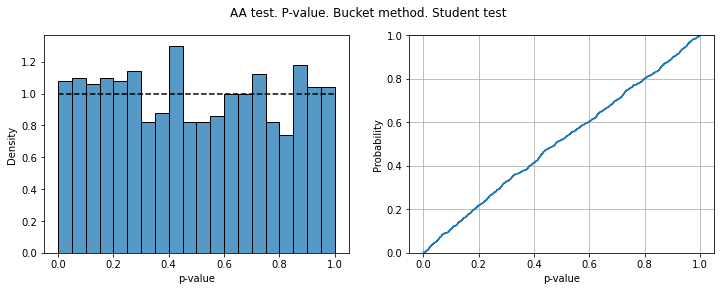

In [6]:
pvalues = get_pvalue_samples_bucket_method()
plot_pvalue_ecdf(pvalues, title='AA test. P-value. Bucket method. Student test')

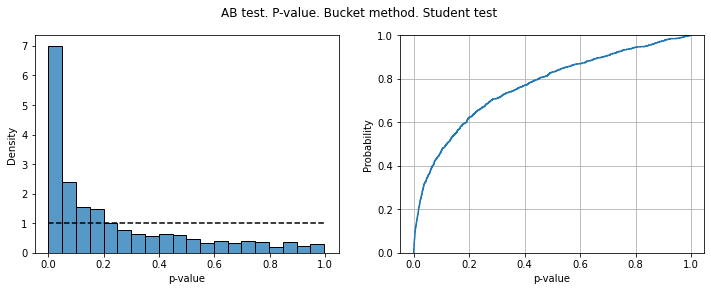

In [7]:
pvalues = get_pvalue_samples_bucket_method(effect=0.05)
plot_pvalue_ecdf(pvalues, title='AB test. P-value. Bucket method. Student test')

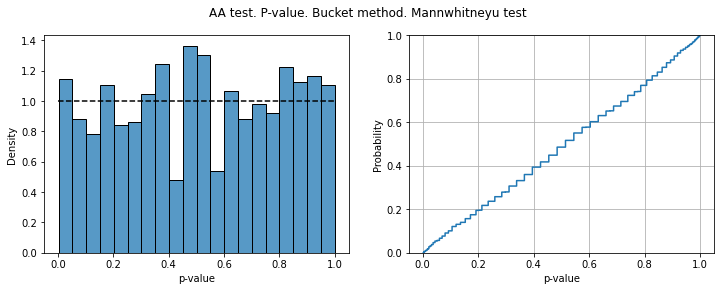

In [8]:
pvalues = get_pvalue_samples_bucket_method(test_name='mannwhitneyu')
plot_pvalue_ecdf(pvalues, title='AA test. P-value. Bucket method. Mannwhitneyu test')

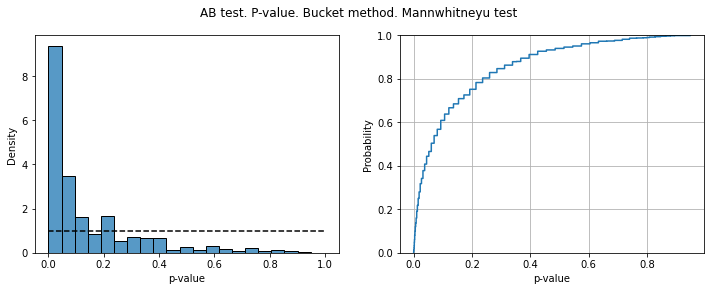

In [9]:
pvalues = get_pvalue_samples_bucket_method(effect=0.05, test_name='mannwhitneyu')
plot_pvalue_ecdf(pvalues, title='AB test. P-value. Bucket method. Mannwhitneyu test')

**Вывод:**

Распределение pvalue обоих статистических тестов на АА-тесте приближенно равномерное, на АВ - нет, что говорит об их корректной работе.

# 2. Метод бакетов vs дельта метод
### (3 балла)
- сравните мощность метода бакетов с мощностью дельта метода
- как меняется соотношение мощностей методов при увеличении размера выборки?

Опишите полученные результаты и приведите подтверждающие численные эксперименты.

**Результаты:**

- Мощность дельта метода на маленьких выборках в разы больше бакетного метода

- С увеличением размера выборки различие в мощностях данных методов практически исчезает.

In [10]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта метод.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    dict_stats = {'a': {'data': a}, 'b': {'data': b}}
    for key, dict_ in dict_stats.items():
        data = dict_['data']
        dict_['x'] = np.array([np.sum(row) for row in data])
        dict_['y'] = np.array([len(row) for row in data])
        dict_['metric'] = np.sum(dict_['x']) / np.sum(dict_['y'])
        dict_['len'] = len(data)
        dict_['mean_x'] = np.mean(dict_['x'])
        dict_['mean_y'] = np.mean(dict_['y'])
        dict_['std_x'] = np.std(dict_['x'])
        dict_['std_y'] = np.std(dict_['y'])
        dict_['cov_xy'] = np.cov(dict_['x'], dict_['y'])[0, 1]
        dict_['var_metric'] = (
            (dict_['std_x'] ** 2) / (dict_['mean_y'] ** 2)
            + (dict_['mean_x'] ** 2) / (dict_['mean_y'] ** 4) * (dict_['std_y'] ** 2)
            - 2 * dict_['mean_x'] / (dict_['mean_y'] ** 3) * dict_['cov_xy']
        ) / dict_['len']
    var = dict_stats['b']['var_metric'] + dict_stats['a']['var_metric']
    delta = dict_stats['b']['metric'] - dict_stats['a']['metric']
    statistic = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(statistic))) * 2
    return pvalue, delta

In [11]:
def get_power_of_test(repeats=1000, size=100, n_bucket=10, effect=0, alpha=0.01, name_of_test='bucket'):
  count_fn = 0
  for i in range(repeats):
    a = get_session_duration(size, effect=0)
    b = get_session_duration(size, effect=effect)
    if name_of_test == 'bucket':
      p, _ = check_bucket(a, b, n_bucket)
    elif name_of_test == 'delta':
      p, _ = check_delta_method(a, b)
      
    count_fn += int(p > alpha)

  return 1 - count_fn / repeats

In [12]:
power_bucket_method = get_power_of_test(effect=0.1)
power_delta_method = get_power_of_test(effect=0.1, name_of_test='delta')

print(f'Power of bucket method: {power_bucket_method}, delta method: {power_delta_method}')

Power of bucket method: 0.605, delta method: 0.728


In [17]:
ratio_powers = []
sizes = [10, 20, 50, 70, 80, 100]

for size in sizes:
  power_bucket_method = get_power_of_test(effect=0.1, size=size)
  power_delta_method = get_power_of_test(effect=0.1, size=size, name_of_test='delta')
  ratio = power_delta_method / power_bucket_method
  ratio_powers.append(ratio)

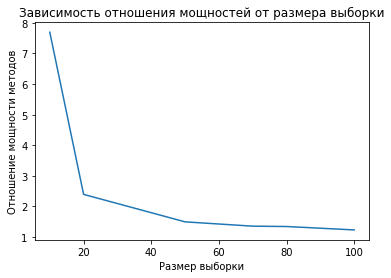

In [18]:
plt.plot(sizes, ratio_powers)
plt.xlabel('Размер выборки')
plt.ylabel('Отношение мощности методов')
plt.title('Зависимость отношения мощностей от размера выборки')
plt.show()

# 3. Оптимальный стат. критерий
### (2 балла)
Какой статистический критерий лучше подходит для метода бакетов: тест Стьюдента или тест Манна-Уитни?

Опишите полученные результаты и приведите подтверждающие численные эксперименты.

**Результаты:**

- Маленькие эффекты лучше улавливаются тестом Манна-Уитни, чем Стьюдента

- Число false positive на АА-тестах меньше для теста Манна-Уитни, чем Стьюдента

- Можно сделать вывод, что тест Манна-Уитни лучше подходит для метода бакетов (кажется, это из-за его устойчивости к выбросам)


In [22]:
# Посмотрим, как эти тесты ловят эффекты
result_tt = []
result_mu = []
effects = [0.01, 0.05, 0.07, 0.1, 0.15, 0.2]

for effect in effects:
  pvalues = get_pvalue_samples_bucket_method(effect=effect)
  answers = [int(el < 0.05) for el in pvalues]

  count_tp = np.count_nonzero(answers)
  result_tt.append((len(answers) - count_tp) / len(answers))

  pvalues = get_pvalue_samples_bucket_method(effect=effect, test_name='mannwhitneyu')
  answers = [int(el < 0.05) for el in pvalues]

  count_tp = np.count_nonzero(answers)
  result_mu.append((len(answers) - count_tp) / len(answers))

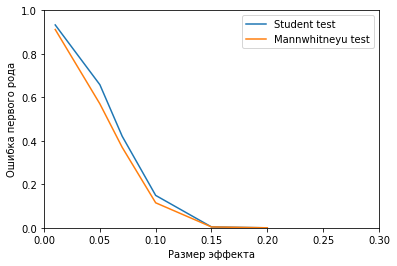

In [24]:
plt.plot(effects, result_tt, label='Student test')
plt.plot(effects, result_mu, label='Mannwhitneyu test')
plt.ylim([0, 1])
plt.xlim(0, 0.3)
plt.xlabel('Размер эффекта')
plt.ylabel('Ошибка первого рода')
plt.legend()
plt.show()

In [26]:
# посмотрим на число ложных срабатываний тестов на АА-тесте

pvalues = get_pvalue_samples_bucket_method(effect=0)
answers = [int(el < 0.05) for el in pvalues]
count_fp_tt = np.count_nonzero(answers)

pvalues = get_pvalue_samples_bucket_method(effect=0, test_name='mannwhitneyu')
answers = [int(el < 0.05) for el in pvalues]
count_fp_mu = np.count_nonzero(answers)

print(f'Число ложных срабатываний Student test: {count_fp_tt}, Mannwhitneyu test: {count_fp_mu}')

Число ложных срабатываний Student test: 59, Mannwhitneyu test: 50


# 4. Оптимальное кол-во бакетов
### (3 балла)
Исследуйте какое кол-во бакетов оптимально?

Опишите полученные результаты и приведите подтверждающие численные эксперименты.

**Результаты:**

Важной особенностью бакетного метода является снижение объема метрик и приведение к нормальному распределению

- В зависимости от числа бакетов были проведены проверки распределения на нормальность, равномерности распределения pvalue для АА-тестов

- С учетом проведенного анализа можно сделать вывод, что 100 (10% размера выборки) является оптимальным значением кол-ва бакетов. В ходе экспериментов было выявлено, что при данном значении выполняется условие нормальности распределения, равномерности pvalue для АА-тестов, а также хорошо снижается размер объема метрики.

In [27]:
# функция для получения бакетов

def get_buckets(a, n_bucket):
    a_buckets = defaultdict(list)
    for i in range(len(a)):
      ind = i % n_bucket
      a_buckets[ind].append(a[i])
    
    a_means = []
    for i in a_buckets.keys():
      a_bucket = []
      for el in a_buckets[i]:
        a_bucket += el.tolist()

      a_means.append(np.mean(a_bucket))
    return a_means

In [28]:
# получим бакеты с разным размером относительно исходного размера выборки

size = 1000
ratios = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
bucket_results = []
a = get_session_duration(size, effect=0)

for ratio in ratios:
  a_means = get_buckets(a, size*ratio)
  bucket_results.append(a_means)

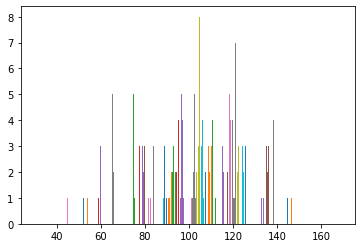

Pvalue для теста на нормальность: 0.0006952316941388674


In [29]:
# распределение исходной выбоки

plt.hist(a)
plt.show()

res_a = []
for i in range(len(a)):
  res_a += a[i].tolist()

_, pvalue = stats.normaltest(res_a)
print(f'Pvalue для теста на нормальность: {pvalue}')

Исходное распределение метрик не является нормальным.

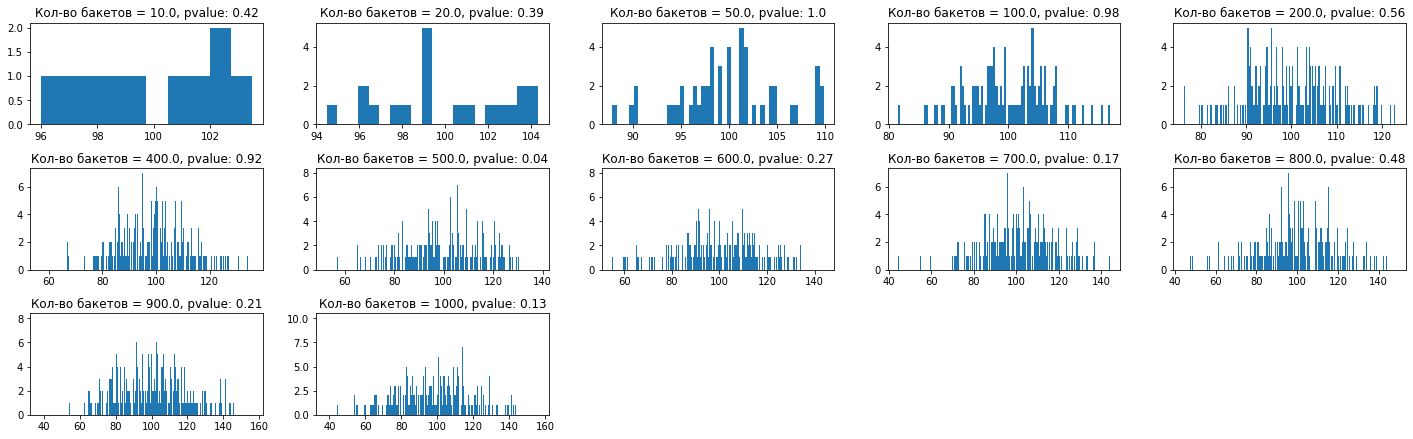

In [30]:
# изобразим распределения при разном кол-ве бакетов

fig = plt.figure(figsize=(20, 10))
for i in range(len(bucket_results)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.hist(bucket_results[i], bins=int(size * ratios[i]))
    _, pvalue = stats.normaltest(bucket_results[i])
    ax.set_title(f'Кол-во бакетов = {size * ratios[i]}, pvalue: {round(pvalue,2)}')

fig.tight_layout()

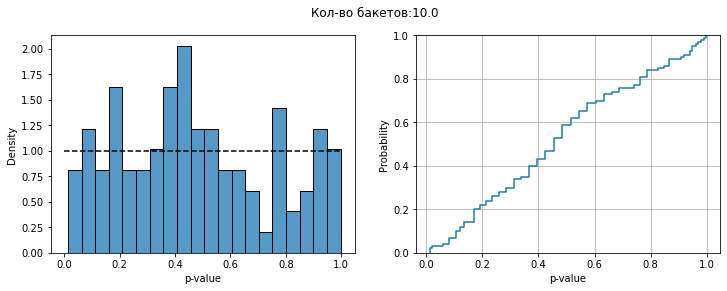

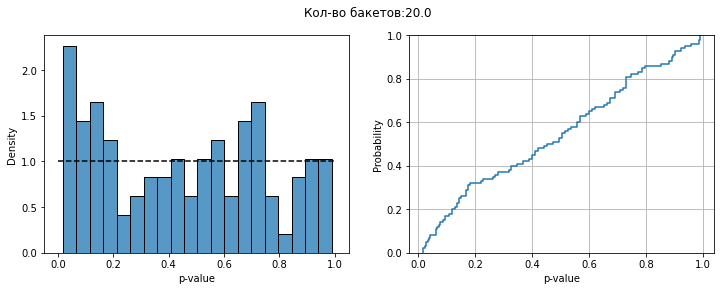

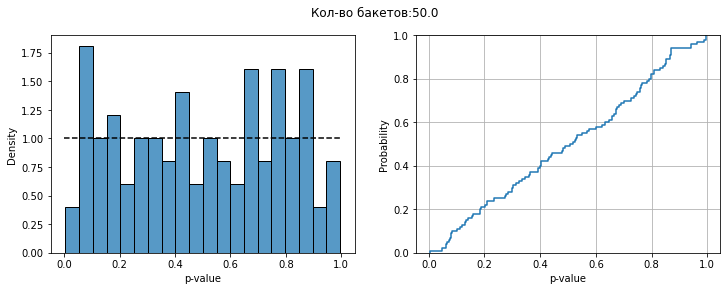

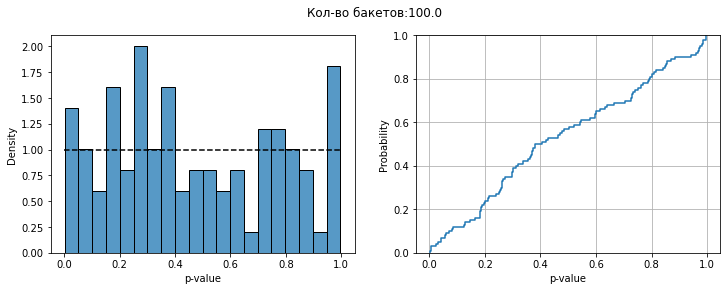

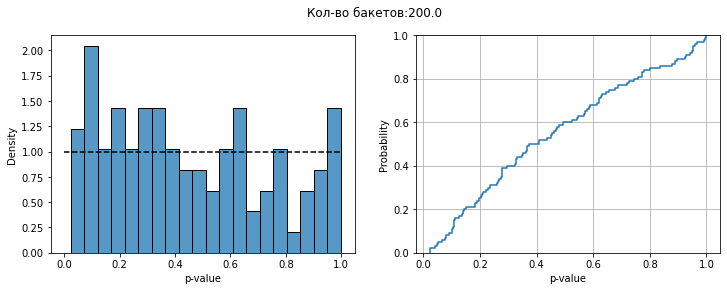

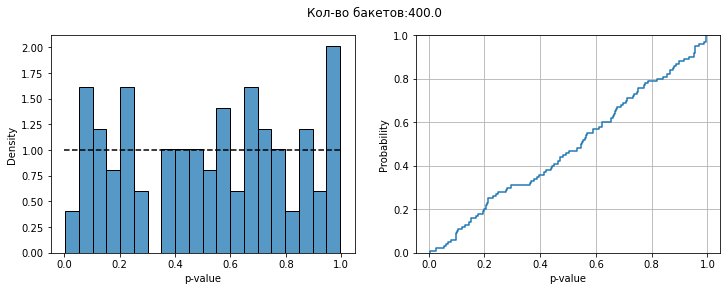

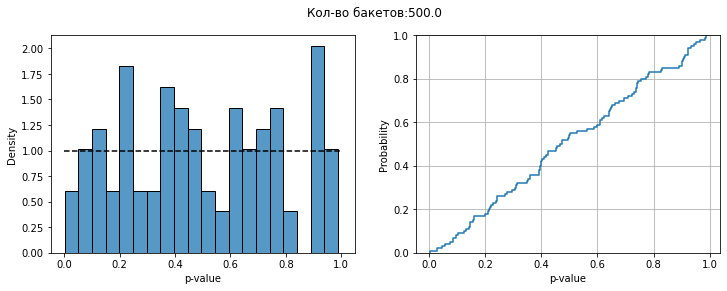

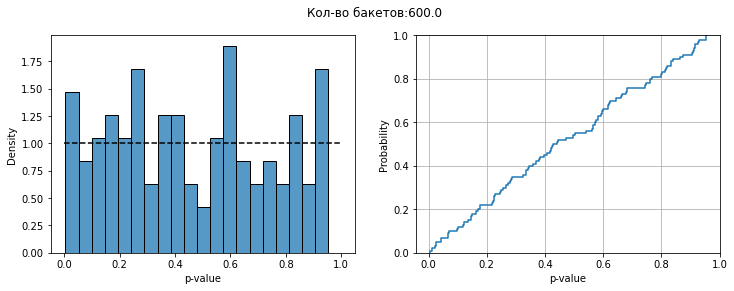

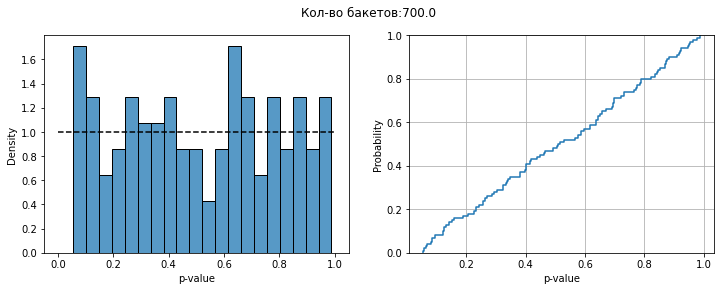

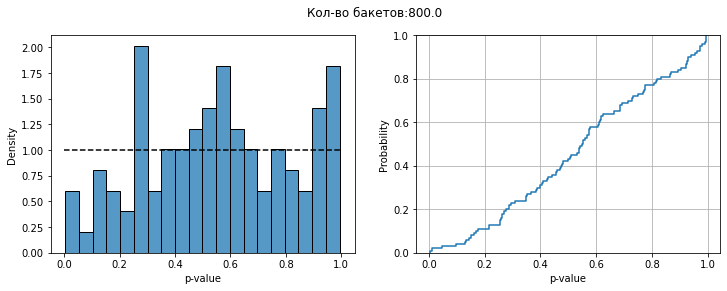

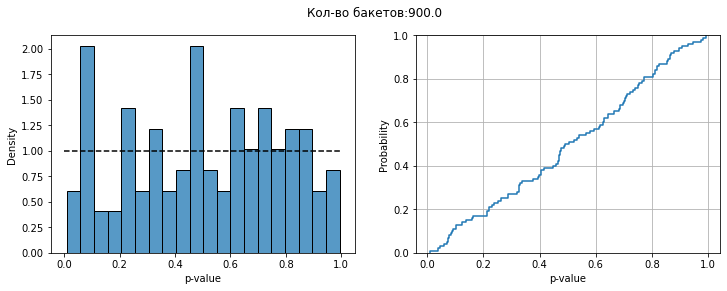

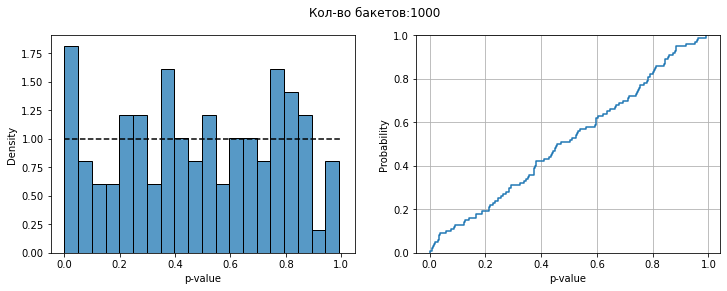

In [31]:
# посмотрим на распределение pvalue для АА-тестов для бакетного метода

ratios = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for ratio in ratios:
  pvalues = get_pvalue_samples_bucket_method(repeats=100, size=1000, effect=0, n_bucket=size*ratio, test_name='mannwhitneyu')
  plot_pvalue_ecdf(pvalues, title=f'Кол-во бакетов:{size*ratio}')

In [32]:
# посмотрим на мощность тестов

test_powers = []
size = 1000

ratios = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for ratio in tqdm(ratios):
  power = get_power_of_test(repeats=100, size=1000, n_bucket=size*ratio, effect=0.05)
  test_powers.append(power)

100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


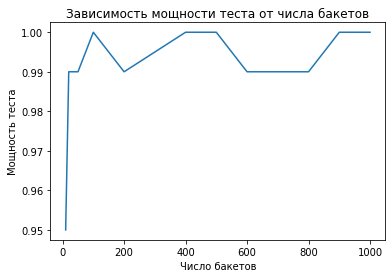

In [33]:
sizes = [size*ratio for ratio in ratios]
plt.plot(sizes, test_powers)
plt.xlabel('Число бакетов')
plt.ylabel('Мощность теста')
plt.title('Зависимость мощности теста от числа бакетов')
plt.show()